In [1]:
import yt
yt.mylog.level = 0

import numpy as np
import matplotlib

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
from amuse.lab import *

import sys
sys.path.append('/home/draco/jwall/amuse/examples/simple')
from clump_finding import *

In [4]:
import yt
from amuse.lab import Particles, units
import numpy as np

def get_ps_from_yt(pltfile, particle_type="all"):
    
    """Take a FLASH plotfile and return an AMUSE
       particle set.
       
       Keyword arguments:
       pltfile      -- The FLASH hdf5 plot or checkpoint file.
                       Note a plotfile means there must also be
                       a particle file with the same ID number.
       particle_type -- the type of particle that you
                         want from FLASH. Can be:
                         star -- active FLASH particle type
                         sink -- sink FLASH particle type
                         any other string or none returns 
                         all particle types.
                         The default is all
       
       Returns:
       stars -- An AMUSE particle set.
    """
    
    ds = yt.load(pltfile)
    dd = ds.all_data()
    
    all_parts_mass = dd['particle_mass'].in_units('Msun')
    all_parts_pos  = dd['particle_position'].in_units('cm')
    all_parts_vel  = dd['particle_velocity'].in_units('cm/s')
    
    if (particle_type == 'star' or particle_type == 'stars'):
        # Index for only the star particles, and not including sink particles.
        mass_ind = np.where(dd['particle_type'].v == 1)
    elif (particle_type == 'sink' or particle_type == 'sinks'):
        mass_ind = np.where(dd['particle_type'].v == 2)
    else:
        mass_ind = np.arange(len(all_parts_mass))
        
    all_parts_mass = all_parts_mass[mass_ind]
    all_parts_pos  = all_parts_pos[mass_ind]
    all_parts_vel  = all_parts_vel[mass_ind]
        
    num_parts = len(all_parts_mass.v)
    
    stars = Particles(num_parts)
    stars.mass     = all_parts_mass.v | units.MSun
    stars.position = all_parts_pos.v  | units.cm
    stars.velocity = all_parts_vel.v  | units.cm/units.s
    stars.index_of_the_particle = range(num_parts)
    
    return stars
    

In [5]:
def plot_clumps(groups, total_mass):
    number_of_particles_in_group = []
    fraction_of_mass_in_group =  []

    for group in groups:
        number_of_particles_in_group.append(len(group))
        fraction = (group.mass.sum()/total_mass)
        fraction_of_mass_in_group.append(fraction)

    figure = pyplot.figure(figsize= (12,6))


    subplot = figure.add_subplot(1, 2, 1)

    colormap = pyplot.cm.Dark2 #pyplot.cm.Paired
    for index, group in enumerate(groups):
        color = colormap(index) #colormap(1.0 * index / len(groups))
        subplot.scatter(
            group.x.value_in(units.parsec),
            group.y.value_in(units.parsec),
            s = group.mass.value_in(units.MSun),
            edgecolors = color,
            facecolors = color,
            label = "{:.2F}".format(fraction_of_mass_in_group[index])
        )

    #subplot.set_xlim(0,1)
    #subplot.set_ylim(0,1)
    subplot.set_xlabel('x (parsec)')
    subplot.set_ylabel('y (parsec)')
    subplot.legend()

    subplot = figure.add_subplot(1, 2, 2)

    subplot.scatter(
        number_of_particles_in_group,
        fraction_of_mass_in_group,
    )

    subplot.set_xscale('log')
    subplot.set_yscale('log')
    subplot.set_xlabel('N')
    subplot.set_ylabel('df/d(Log_10 N)')

    #figure.savefig('x.png')
    pyplot.show()

In [6]:
data_dir  = "Runs/CartM3V02A/data/"
file_name = "turbsph_hdf5_plt_cnt_"
file_num  = "5472"

fn = data_dir+file_name+file_num

ds = yt.load(fn)
print ds.current_time.in_units('Myr')

stars = get_ps_from_yt(fn)


3.87912000532 Myr


/home/draco/jwall/usr/local/lib/python2.7/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/home/draco/jwall/usr/local/lib/python2.7/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f


In [7]:
stars_total_E = stars.kinetic_energy() + stars.potential_energy()
stars_total_M = stars.mass.sum()
conv = nbody_system.nbody_to_si(stars_total_M, stars_total_E)

In [8]:
hop = Hop(unit_converter=conv)

hop.number_of_neighbors_for_hop = 12
hop.relative_saddle_density_threshold = True
hop.set_relative_saddle_density_threshold(True)
hop.set_nHop(16)
print hop.parameters
hop.particles.add_particles(stars)
hop.calculate_densities()
hop.do_hop()

n_groups = hop.get_number_of_groups()
print n_groups
#hop.stop()

density_method: 0 default: 0
number_of_buckets: 16 default: 16
number_of_neighbors_for_hop: -1 default: 64
number_of_neighbors_for_local_density: 64 default: 64
number_of_particles_per_group_pair_boundary: 4 default: 4
outer_density_threshold: -1.89116298787e-14 m**-3 * kg default: -1.89116298787e-14 m**-3 * kg
peak_density_threshold: -1.89116298787e-14 m**-3 * kg default: -1.89116298787e-14 m**-3 * kg
relative_saddle_density_threshold: True default: False
saddle_density_threshold: -1.89116298787e-14 m**-3 * kg default: -1.89116298787e-14 m**-3 * kg
saddle_density_threshold_factor: 0.8 default: 0.8

2


In [9]:
groups = [x.get_intersecting_subset_in(stars) for x in hop.groups()]

In [10]:
print hop.get_average_boundary_density_of_groups(0,1).in_(units.MSun*units.parsec**-3)
print hop.get_saddle_densthresh()

614.855911117 MSun * parsec**-3
-3.30953522877e-14 m**-3 * kg


In [11]:
hop.stop()

/home/draco/jwall/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


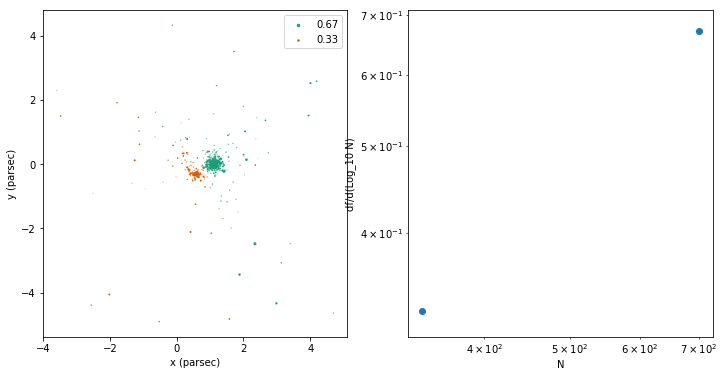

In [12]:
#groups = find_clumps(stars, conv)
#print groups
plot_clumps(groups, stars_total_M)

In [7]:
print groups[0]

                 key  index_of_the_particle         mass           vx           vy           vz            x            y            z
                   -         none         MSun       cm / s       cm / s       cm / s           cm           cm           cm
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
18215833412810052103            0    3.832e-02   -1.429e+05    5.337e+04   -1.542e+05   -1.169e+18   -1.761e+18   -8.165e+18
 1400798065298037076            1    8.844e-01   -2.375e+05   -2.133e+05   -1.418e+05   -6.098e+18   -1.241e+19   -6.721e+18
14212738412107647867            2    3.006e-02   -2.521e+05    1.693e+04   -5.978e+04   -7.616e+18   -2.809e+18   -2.695e+18
10082111491615199091            3    1.410e-02   -3.867e+05   -5.987e+04   -6.781e+04   -2.672e+18   -2.349e+18   -2.645e+18
16658356430828477544            4    5.610e-01    3.522e+04   -4.270e+05   -2.413e+05    4.856e+18   -1.465e+19   -

/home/draco/jwall/amuse/src/amuse/datamodel/particles.py:286: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if numpy.issubdtype(quantity.dtype, float):


In [8]:
part = stars.position.number

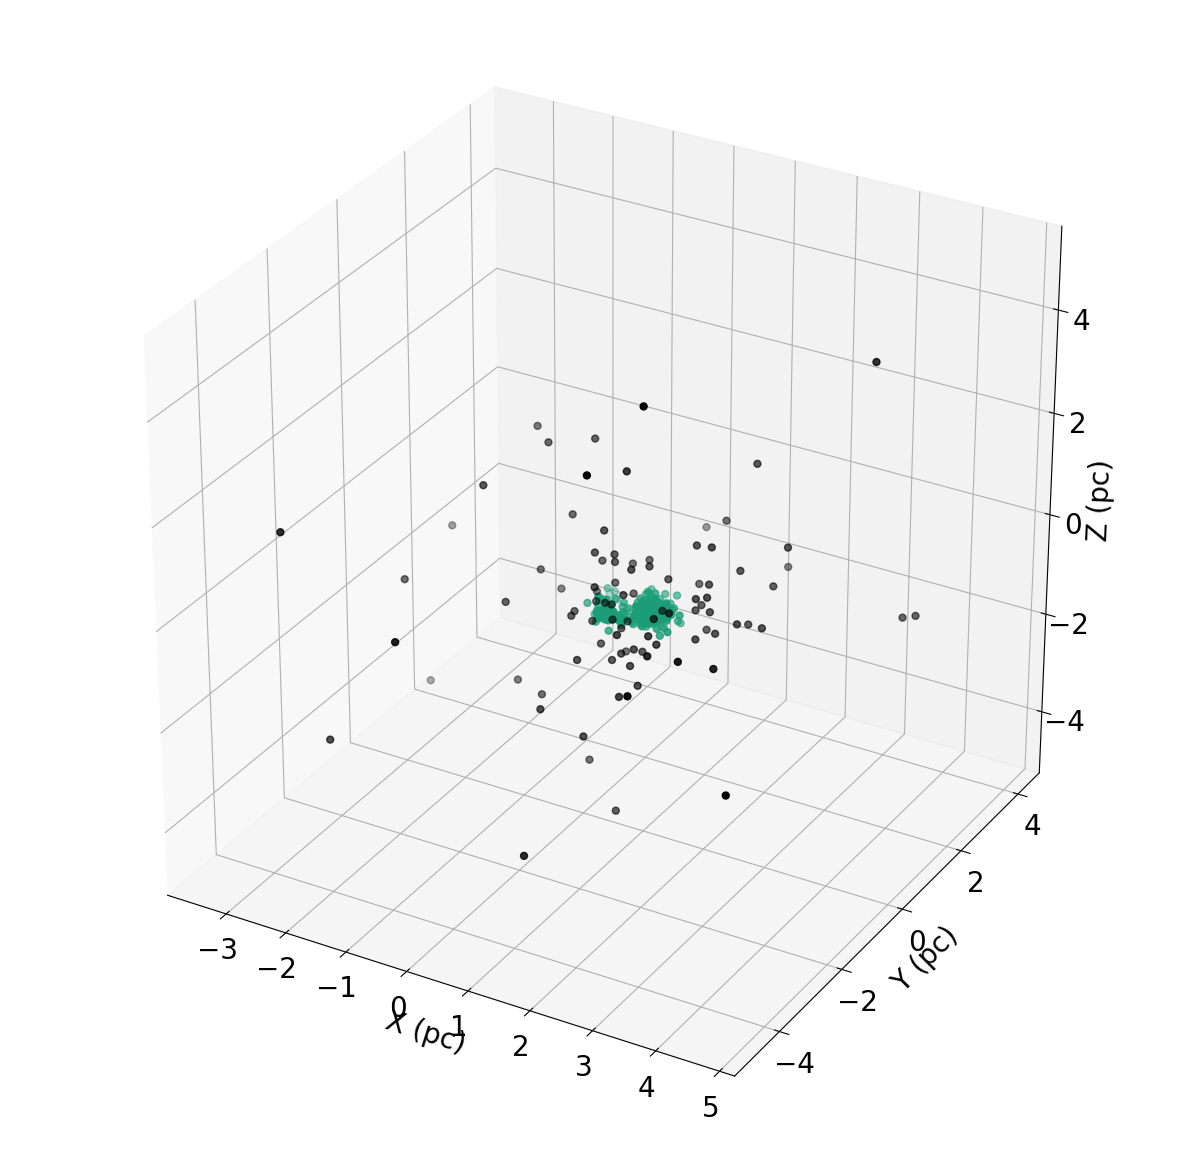

In [9]:
from scipy.spatial import distance

from sklearn.cluster import KMeans

pc = 3.086e18

#part = np.vstack([part[:,0],part[:,1],part[:,2]]).T

#X = np.random.normal(size=(1000,2)) #1000 points in 2D
#clf = KMeans(n_clusters=3,n_init=20) #Try 3 clusters to start with
#labels=clf.fit_predict(part)
#centers=clf.cluster_centers_ #location of the clusters
#labels=clf.predict(part) #labels for each of the points



# To get some information on these try:
# KMeans?
# help(clf)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

slcpart = StandardScaler().fit_transform(part)

db = DBSCAN(eps=0.5, min_samples=5, leaf_size=7)

clstr = db.fit_predict(slcpart)

labels = db.labels_

unique_labels = set(labels)
colors = plt.cm.Dark2(np.linspace(0, 1, len(unique_labels)))

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = part[class_member_mask]
    ax.scatter(xy[:, 0]/pc, xy[:, 1]/pc, xy[:,2]/pc, marker='o', c=col,
             s=25)

#ax.scatter(centers[:, 0]/pc, centers[:, 1]/pc, centers[:,2]/pc,
#           s=200, c='w', edgecolors='k', alpha=0.3)

ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')


#ax.set_xlim(-10, 20)
#ax.set_ylim(-15., 15.)
#ax.set_zlim(10., 40.)

#ax.set_title("DBSCAN clustering of run at %.2f" %ds.current_time.in_units("Myr") + " Myr")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
    item.set_fontsize(20)

plt.show()
#plt.clf()

#print clstr
